# Machine Learning LAB 1: MODEL SELECTION

Course 2024/25: *F. Chiariotti*

The notebook contains a simple learning task over which we will implement **MODEL SELECTION AND VALIDATION**.

Complete all the **required code sections** and **answer all the questions**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Polynomial Classification on Signal to Noise Ratios

In this notebook we are going to explore the use of polynomial classification with polynomial regression. We are going to use the Numpy **polyfit** function, which performs polynomial regression.

Our use case is a communication problem: we have a set of measurements of the Signal to Noise Ratio (SNR), i.e., the quality of the communication link, in various positions. The SNR depends on two components: firstly, the noise level (which is a random variable that does not depend on position) and the signal attenuation (usually modeled as a polynomial function of the distance).

Our transmitter is in (0,0), and coordinates are in meters. In urban scenarios, the attenuation usually follows a third-degree polynomial, but it might be a fourth- or fifth-degree polynomial in more complex cases. How do we choose between different degrees? We will try with a maximum of **6**

---

## Import all the necessary Python libraries

In [1]:
import numpy as np
import random
import scipy as sp
import pandas as pd
import itertools
from matplotlib import pyplot as plt

---

## Load the data

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [2]:
df = pd.read_csv('data/snr_measurements.csv',sep=';')
x = df['x'].values    #convert pandas dataframe to numpy arrays
y = df['y'].values
SNR = df['SNR'].values          #or SNR = df['SNR'].to_numpy()

## Helper functions

These functions will help us evaluate the results

In [ ]:
def compute_distance(x, y):
    distance=(x**2+y**2)**(1/2)
    return distance

def fit(distance, SNR, degree):
    return np.polyfit(distance, SNR, deg=degree)     #is an array of degree+1 elements of polynomial coefficient from highest degree to x^^0

def predict(distance, poly_coeffs, degree):
    # Predict the SNR from a given model
    SNR=sum([poly_coeffs[degree-deg]* distance**deg for deg in range(degree+1)])
    return SNR      #is an array of predicted SNR

def evaluate(distance, SNR, poly_coeffs, degree):
    # Compute the error of the polynomial fit on the chosen data with mean square error
    mse=(predict(distance, poly_coeffs, degree)-SNR)**2
    MSE=sum(mse)
    return MSE

def separate_test(distance, SNR, test_points):
    # Return a training set and a test set (the test_points parameter controls the number of test points).
    # The points should be selected randomly, so i first create an array of random indices of size test_points
    idx=list(range(len(distance)))
    testidx=random.sample(idx, test_points)    #without replacement random.sample(), otherwise shuffle and the pick first n points
    trainidx=[i for i in idx if i not in testidx]
    distance_train=distance[trainidx]
    distance_test=distance[testidx]
    SNR_train=SNR[trainidx]
    SNR_test=SNR[testidx]
        
    return distance_train, SNR_train, distance_test, SNR_test

Text(0, 0.5, 'SNR')

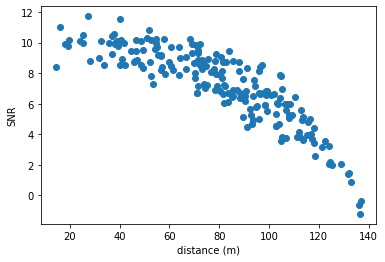

In [4]:
# separate the training and test sets and create a scatter plot of the SNR as a function of the distance
distance = compute_distance(x,y)
(dist_train, SNR_train, dist_test, SNR_test)=separate_test(distance, SNR, 40)

plt.plot(distance, SNR, 'o')
plt.xlabel('distance (m)')
plt.ylabel('SNR')

## A. K-fold cross-validation

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

In [31]:
# Function to perform the K-fold cross validation
def k_fold_cross_validation(x_train: np.ndarray, y_train: np.ndarray, k: int, max_degree: int) -> tuple[tuple, tuple]:
    # TODO: Perform K-fold cross-validation on the training set.
    # The two returned values are the best model (coefficient) and the list of results (performance) for all degrees up to max_degree.
    # The points should be selected randomly.
    idx=list(range(len(x_train)))
    fold_points=int(np.floor(len(x_train)/k))
    x_fold=[]
    y_fold=[]
    for i in range(k):                              #partition into folds
        fold_idx=random.sample(idx, fold_points)
        idx= [i for i in idx if i not in fold_idx]
        x_fold.append(x_train[fold_idx])
        y_fold.append(y_train[fold_idx])

    #print("x_folds: ", x_fold)

    best=-1
    best_perf=9e10
    results=[]

    for degree in range(max_degree+1):
        deg_perf=0
        for i in range(k):
            x_k_train= np.concatenate([x_fold[l] for l in range(k) if l!=i])
            #print(i, "validation set:", x_fold[i], "test set: ", x_k_train)
            y_k_train= np.concatenate([y_fold[l] for l in range(k) if l!=i])
            p=fit(x_k_train,y_k_train, degree)
            deg_perf+=evaluate(x_fold[i], y_fold[i], p, degree)
        deg_perf/=k
        results.append(deg_perf)
        if deg_perf<best_perf:
            best_perf=deg_perf
            best=fit(x_train, y_train, degree)

    # The inputs and labels are already in terms of distance and SNR
    return best, results

(array([-4.80516563e-06,  2.75956145e-04, -2.31015063e-02,  1.04092446e+01]), [231.19680214636418, 62.22096986559636, 39.00248880556574, 38.291643189693694, 38.44858269349496, 38.880369309951156, 38.58630029611435])


Text(0, 0.5, 'validation performance')

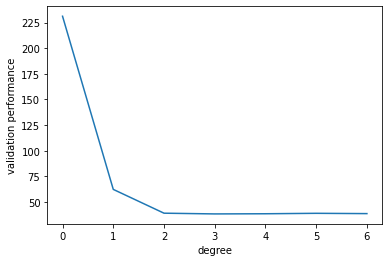

In [ ]:
k_fold_results=k_fold_cross_validation(dist_train, SNR_train, 4, 6)

plt.plot(k_fold_results[1])
plt.xlabel("degree")
plt.ylabel("validation performance")

Text(0.5, 1.0, 'K-fold validation')

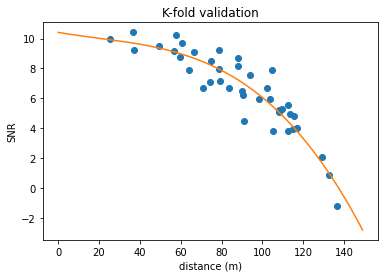

In [44]:
#  get the test performance of the best model and plot the model output and test points. 
k_coeff=k_fold_results[0]
k_deg=len(k_fold_results[0])-1

k_perf=evaluate(dist_test, SNR_test, k_coeff, k_deg)

k_predict=predict(np.arange(150), k_coeff, k_deg)

plt.plot(dist_test, SNR_test, 'o')
plt.plot(np.arange(150), k_predict)
plt.xlabel('distance (m)')
plt.ylabel('SNR')
plt.title('K-fold validation')
# Try running the program multiple times, changing the values of K and the number of test points: is the output always the same?

---

## B. Tikhonov regularization

Change the loss function to include a Tikhonov regularization term, as an alternative to cross-validation (try $\lambda=1$) THIS GETS VERY STRONG REGULARIZATION, TRY $\lambda=0.01$

In [8]:
def evaluate_tikhonov(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    # TODO: apply Tikhonov regularization AFTER the fitting process

    return best, results

In [9]:
# TODO: run the training with Tikhonov regularization and plot the loss as a function of the degree


## C. Minimum description length regularization

Change the loss function to include a representation length regularization term, as an alternative to cross-validation. The minimum description length of a polynomial of degree N is O(2^N) - try $\lambda=1$

In [10]:
def evaluate_representation(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    # TODO: apply Tikhonov regularization AFTER the fitting process

    return best, results

In [11]:
# TODO: run the training with MDL regularization and plot the loss as a function of the degree

### TEST

Check the performance of the three solutions on the test set: which one does best?


In [12]:
# TODO: plot the results